In [2]:
import sys
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
%config InlineBackend.figure_format = 'png'

import scripts.statistics as stats
import scripts.get_namelist as nml

def which_tID(tvec,t):
    tID = np.argmin(np.abs(tvec-t))
    return tID

# Thickness and growth rates
def get_dtheta(directory,time):
    filename_prefix = directory+'/shearlayer_'
    tlist,dtheta,rate = growth_rates(filename_prefix)
    idx = np.argmin(abs(tlist-time))
    return dtheta[idx]

def growth_rates(filename_prefix):
    fname = filename_prefix+'growth.dat'
    dat = np.fromfile(fname,dtype=float, count=-1, sep=' ')
    n = np.size(dat)
    nstats=3
    dat = np.reshape(dat,[n/nstats,nstats])
    time = dat[:,0]
    dtheta = dat[:,1]
    rate = dat[:,2]
    return time,dtheta,rate

def which_tID(tvec,t):
    tID = np.argmin(np.abs(tvec-t))
    return tID

# get centerline from Reynolds stresses (vector)
def get_centerline(directory,y,time):
    nmodes = 10
    dat = np.fromfile( directory + 'shearlayer_Rij_'+str(tID)+'.dat',dtype=float, count=-1, sep=' ')
    n = np.size(dat)
    nstats=6
    dat = np.reshape(dat,[n/nstats,nstats]) 
    yc = 0
    for i in [0,1]:
        ic = np.argmax(smooth_modes(abs(dat[:,i]),nmodes))
        yc += y[ic]
    yc /= 2.    
    ic = np.argmin(abs(y-yc))
    return ic,y[ic]

def smooth_modes(f,nmodes):
    fhat = np.fft.fft(f)
    fhat[nmodes+1:-(nmodes+1):] = 0
    f = np.fft.ifft(fhat)
    return f

In [3]:
# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc02/rr1/1024x1448x512/'
# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc02/rr7/1024x1448x512/'
# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc02/rr_7/1024x1448x512/'

# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc04/rr1/1024x1448x512/'
# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc08/rr1/1024x1448x512/'
# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc08/rr7/1024x1448x512/'
# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc08/rr_7/1024x1448x512/'

# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc12/rr1/1024x1448x512/'
# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc16/rr1/1024x1448x512/'
directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc20/rr1/1024x1448x512/'
# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc20/rr7/1024x1448x512/'
# directory = '/projects/ShockInducedMix/ShearLayerData/production/Mc20/rr_7/1024x1448x512/'

inp = nml.inputs(directory,verbose=True)
Nx,Ny,Nz,Lx,Ly,Lz = nml.read_grid_params(directory,verbose=True)
Ny = int(Ny)
y = np.linspace(-Ly/2.,Ly/2.,Ny)

flist = glob.glob(directory+"*Mt*")
flist.sort()
print([f.split('/')[-1] for f in flist])

# And read growth rates
tlist,dlist,rates = growth_rates(directory+'shearlayer_')

Params for this run:
	Mc = 2.0
	Re = 1000.0
	rr = 1.0
Params for this grid:
	N = 1024x1448x512
	L = 80.0x80.0x40.0
['shearlayer_Mt_0004.dat', 'shearlayer_Mt_0005.dat', 'shearlayer_Mt_0006.dat', 'shearlayer_Mt_0007.dat', 'shearlayer_Mt_0008.dat']


/projects/ShockInducedMix/ShearLayerData/production/Mc20/rr1/1024x1448x512/
Mt mean, std: [0.363569241177, 0.0141598427806]


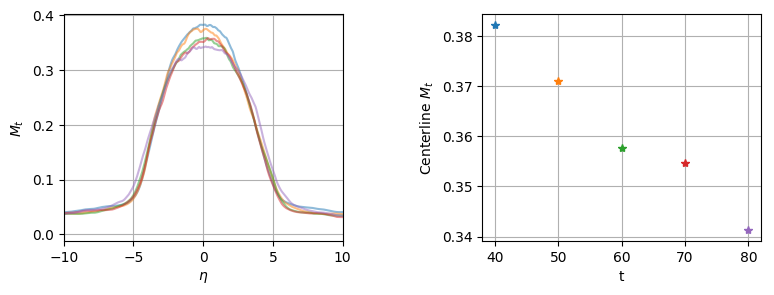

In [51]:
# vv correlation profiles
fig,ax = plt.subplots(1,2,figsize=(9,3), dpi=100)

flist_plot = flist[::]
Mts = np.zeros(len(flist_plot))

for count,fname in zip(range(len(flist_plot)),flist_plot):
    tID = fname.split('_')[-1]
    tID = tID.split('.dat')[0]
    time = nml.read_time(directory,tID)
    
    # Get eta
    dtheta = get_dtheta(directory,time)
    eta = y/dtheta
    
    # Get centerline
    ic,yc = get_centerline(directory,y,time)
    
    # Get turb Mach
    Mt = np.fromfile(fname,dtype=float, count=-1, sep=' ')
    ax[0].plot(eta, Mt, alpha=0.5,label='t=%d'%time)
   
    # Record for later
    ax[1].plot(time,Mt[ic],'*')
    Mts[count] = max(Mt)

# ax[0].legend()
ax[0].set_xlim([-10,10])
ax[0].set_xlabel(r'$\eta$')
ax[0].set_ylabel('$M_t$')
ax[1].set_xlabel(r'$\eta = y/\delta_\theta$')
ax[1].set_xlabel('t')
ax[1].set_ylabel('Centerline $M_t$')
for a in ax:
    a.grid(True)
plt.subplots_adjust(wspace = 0.5)   

idx = 0
print(directory)
print("Mt mean, std: [{}, {}]".format(np.mean(Mts[idx:]),np.std(Mts[idx:])))

# ax[0].legend(bbox_to_anchor=(0.8, 0.35))
plt.savefig(directory+'/img/Mt.png',dpi=200, bbox_inches='tight')

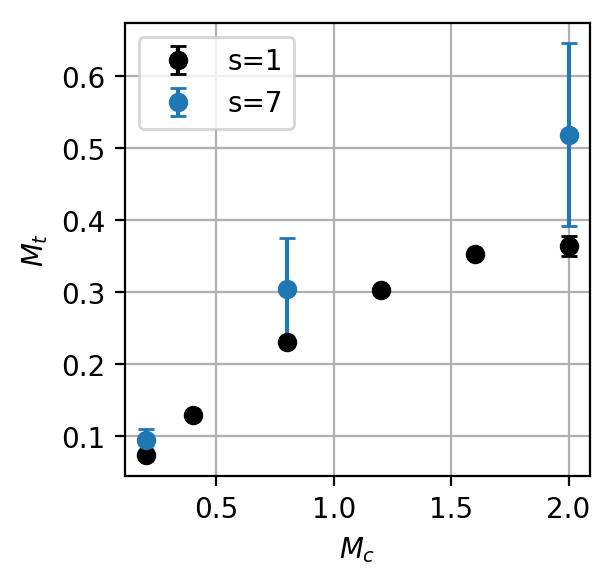

In [19]:

Mt = {
    0.2: [0.0743177180471, 0.000730863508898],
    0.4: [0.129623040187, 0.00149312418738],
    0.8: [0.230127848754, 0.00239627385935],
    1.2: [0.302618032114, 0.00334932924775],
    1.6: [0.352224166278, 0.0055459964092],
    2.0: [0.363569241177, 0.0141598427806] }

Mt_rr7 = {
    0.2: [0.0842955344513, 0.00211863961959],
    0.8: [0.260300674361, 0.0226345206423],
    2.0: [0.427610732933, 0.0342645516652] }

Mt_rr_7 = {
    0.2: [0.104198858115, 0.00574291667634],
    0.8: [0.348601926404, 0.0128486074952],
    2.0: [0.609448033317, 0.010657584979] }

Mt_freund = {
    0.09912686624827222: 0.05881332795315808,
    0.20204847308910773: 0.12291525365522804,
    0.4080977360337234: 0.23683302282854135,
    0.5798140405401926: 0.3311692437133512,
    0.7899928741296565: 0.4254367815105128,
    0.9812495170720399: 0.4983095375052586,
    1.27250873563021: 0.571003717472119,
    1.5291774341715532: 0.6419739519390095,
    1.7812529512264226: 0.7647381028014115}

def merge_dicts(old1,old2):
    new = {}
    for i in range(3):
        key = old1.keys()[i]
        v1 = old1.values()[i][0]
        v2 = old2.values()[i][0]
        e1 = old1.values()[i][1]
        e2 = old2.values()[i][1]
        err = (e1**2+e2**2)**0.5 + np.std([v1,v2])
        new[key] = [(v1+v2)/2., err]
    return new

rr = merge_dicts(Mt_rr7,Mt_rr_7)

fs = 14
fig = plt.figure(figsize=(3,3),dpi=200)
plt.errorbar(Mt.keys(),[x[0] for x in Mt.values()], yerr=[x[1] for x in Mt.values()],fmt='ko',label='s=1',capsize=3)
# plt.errorbar([k+0.02 for k in Mg_rr7.keys()],[x[0] for x in Mg_rr7.values()], yerr=[x[1] for x in Mg_rr7.values()],fmt='o',label='s=7',capsize=3)
# plt.errorbar([k-0.02 for k in Mg_rr_7.keys()],[x[0] for x in Mg_rr_7.values()], yerr=[x[1] for x in Mg_rr_7.values()],fmt='o',label='s=1/7',capsize=3)
# plt.plot(Mg_Freund.keys(),Mg_Freund.values(),'o',label='Freund 2000')
plt.errorbar(rr.keys(),[x[0] for x in rr.values()], yerr=[x[1] for x in rr.values()],fmt='o',label='s=7',capsize=3)


plt.grid(True)
plt.legend()
plt.xlabel(r'$M_c$')
plt.ylabel(r'$M_t$')
plt.savefig('/home/kmatsuno/ShearLayer_img/Mt.png',dpi=200, bbox_inches='tight')

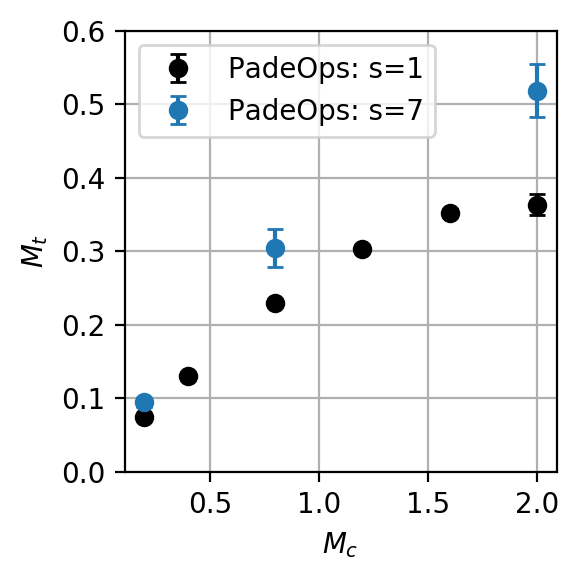

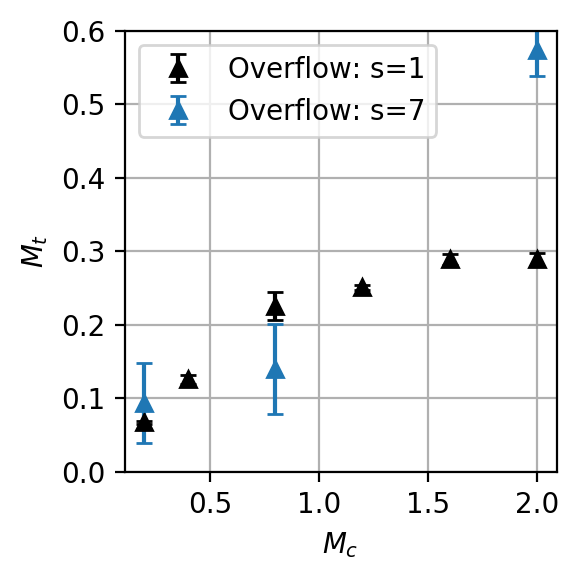

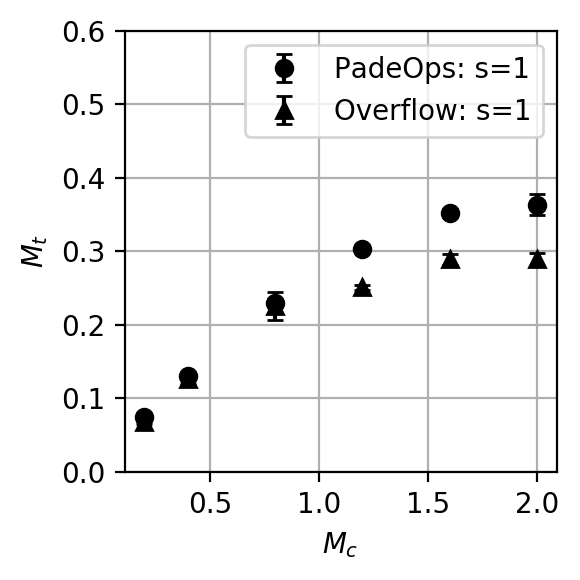

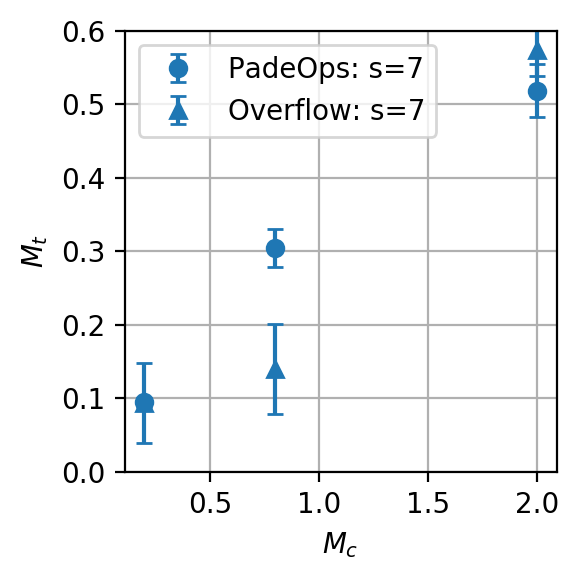

In [41]:
#OVERFLOW
Mt_ovf = {
    0.2: [0.067, 0.002],
    0.4: [0.126, 0.006],
    0.8: [0.226, 0.019],
    1.2: [0.251, 0.003],
    1.6: [0.289, 0.008],
    2.0: [0.289, 0.009] }
Mt_rr7_ovf = {
    0.2: [0.11, 0.05],
    0.8: [0.152, 0.043],
    2.0: [0.550, 0.035] }
Mt_rr_7_ovf = {
    0.2: [0.077, 0.02],
    0.8: [0.128, 0.044],
    2.0: [0.599, 0.008] }

DPI=200 
def make_nice():
    plt.legend()
    plt.grid(True)
    plt.xlabel(r'$M_c$')
    plt.ylabel(r'$M_t$')
    plt.ylim([0,0.6])
    plt.tight_layout()
Lvv = Mt
Lvv_rr_7 = Mt_rr_7
Lvv_rr7 = Mt_rr7
Lvv_ovf = Mt_ovf
Lvv_rr_7_ovf = Mt_rr_7_ovf
Lvv_rr7_ovf = Mt_rr7_ovf

DPI=200 
prefix = '/home/kmatsuno/Ovf_compare/Mt_'

rr_ovf = merge_dicts(Lvv_rr7_ovf,Lvv_rr_7_ovf)

fig = plt.figure(figsize=(3,3),dpi=DPI)
plt.errorbar(Lvv.keys(),[x[0] for x in Lvv.values()], yerr=[x[1] for x in Lvv.values()],fmt='ko',label='PadeOps: s=1',capsize=3)
# plt.errorbar(Lvv_rr_7.keys(),[x[0] for x in Lvv_rr_7.values()],yerr=[x[1] for x in Lvv_rr_7.values()],fmt='o',label='PadeOps: s=1/7',color='C0',capsize=3)
# plt.errorbar(Lvv_rr7.keys(),[x[0] for x in Lvv_rr7.values()], yerr=[x[1] for x in Lvv_rr7.values()],fmt='o',label='PadeOps: s=7',color='C1',capsize=3)
plt.errorbar(rr.keys(),[x[0] for x in rr.values()], yerr=[x[1] for x in rr.values()],fmt='o',label='PadeOps: s=7',capsize=3)
make_nice()
plt.savefig(prefix+'padeops.png',dpi=DPI, bbox_inches='tight')

fig = plt.figure(figsize=(3,3),dpi=DPI)
plt.errorbar(Lvv_ovf.keys(),[x[0] for x in Lvv_ovf.values()],yerr=[x[1] for x in Lvv_ovf.values()],fmt='k^',label='Overflow: s=1',capsize=3)
# plt.errorbar(Lvv_rr_7_ovf.keys(),[x[0] for x in Lvv_rr_7_ovf.values()], yerr=[x[1] for x in Lvv_rr_7_ovf.values()],fmt='^',color='C0',label='Overflow: s=1/7',capsize=3)
# plt.errorbar(Lvv_rr7_ovf.keys(),[x[0] for x in Lvv_rr7_ovf.values()], yerr=[x[1] for x in Lvv_rr7_ovf.values()],fmt='^',color='C1',label='Overflow: s=7',capsize=3)
plt.errorbar(rr_ovf.keys(),[x[0] for x in rr_ovf.values()], yerr=[x[1] for x in rr_ovf.values()],fmt='^',label='Overflow: s=7',capsize=3)
make_nice()
plt.savefig(prefix+'ovf.png',dpi=DPI, bbox_inches='tight')

fig = plt.figure(figsize=(3,3),dpi=DPI)
plt.errorbar(Lvv.keys(),[x[0] for x in Lvv.values()], yerr=[x[1] for x in Lvv.values()],fmt='ko',label='PadeOps: s=1',capsize=3)
plt.errorbar(Lvv_ovf.keys(),[x[0] for x in Lvv_ovf.values()],yerr=[x[1] for x in Lvv_ovf.values()],fmt='k^',label='Overflow: s=1',capsize=3)
make_nice()
plt.savefig(prefix+'rr1.png',dpi=DPI, bbox_inches='tight')

fig = plt.figure(figsize=(3,3),dpi=DPI)
plt.errorbar(rr.keys(),[x[0] for x in rr.values()],yerr=[x[1] for x in rr.values()],fmt='o',label='PadeOps: s=7',color='C0',capsize=3)
plt.errorbar(rr_ovf.keys(),[x[0] for x in rr_ovf.values()], yerr=[x[1] for x in rr_ovf.values()],fmt='^',color='C0',label='Overflow: s=7',capsize=3)
make_nice()
plt.savefig(prefix+'rr7.png',dpi=DPI, bbox_inches='tight')

